In [1]:
%matplotlib inline

## Hyperparameters

In [2]:
MAX_SENTENCE_LENGTH = 200
training_epochs = 100
batch_size = 512
# nb_classes = 20
nb_classes = 2

dataset_name = '20ng'
args = {}
args['is_hierarchical'] = False
args['max_sentence_length'] = MAX_SENTENCE_LENGTH
args['embedding_type'] = 'word2vec'
args['lambda_word'] = 5
args['embedding_dim'] = 300
args['attention_dim'] = 300
args['rnn_dim'] = 300
args['mu_classification'] = 1.0
args['mu_supervision'] = 2.0
args['include_dense_batch_normalization'] = False
args['include_dense_dropout'] = True
args['nb_dense'] = 1
args['dense_dim'] = 300
args['dense_dropout'] = 0.5
# args['decay'] = 2

## Dataset Preparation

In [3]:
# refer: http://ai.stanford.edu/~amaas/data/sentiment/

import os
import pickle
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from sklearn.datasets import fetch_20newsgroups
categories = ["rec.sport.baseball", "rec.sport.hockey"]

data_dir = "./datasets/20news-bydate"
# train_dir = os.path.join(data_dir, '20news-bydate-train')
# test_dir = os.path.join(data_dir, '20news-bydate-test')

def load_dataset(split):
    cache_dir = os.path.join(data_dir, 'cached')
#     x_filepath = os.path.join(cache_dir, 'x_{}_{}.np'.format(split, MAX_SENTENCE_LENGTH))
#     y_filepath = os.path.join(cache_dir, 'y_{}_{}.np'.format(split, MAX_SENTENCE_LENGTH))
#     el_filepath = os.path.join(cache_dir, 'el_{}_{}.np'.format(split, MAX_SENTENCE_LENGTH))
    x_filepath = os.path.join(cache_dir, 'x_{}_300.np'.format(split))
    y_filepath = os.path.join(cache_dir, 'y_{}_300.np'.format(split))
#     el_filepath = os.path.join(cache_dir, 'el_{}_300.np'.format(split))
    
    if os.path.exists(x_filepath):
        with open(x_filepath, 'rb') as fp:
            x_data = pickle.load(fp)
        with open(y_filepath, 'rb') as fp:
            y_data = pickle.load(fp)
#         with open(el_filepath, 'rb') as fp:
#             el_data = pickle.load(fp)
        
    else:            
        newsgroups = fetch_20newsgroups(subset=split,
                                        remove=('headers', 'footers', 'quotes'),
                                        categories=categories)
    
        x_data = []
        y_data = []
#         el_data = []

        for review, y in tqdm(zip(newsgroups.data, newsgroups.target)):
            try:
                prediction = predictor.predict(sentence=review)
            except:
                continue

#             tags = [0 if tag == 'O' else 1 for tag in prediction['tags']]

            x_data.append(prediction['words'])
#             el_data.append(tags)
            y_data.append(y)
        
        with open(x_filepath, 'wb') as fp:
            pickle.dump(x_data, fp)
        with open(y_filepath, 'wb') as fp:
            pickle.dump(y_data, fp)
#         with open(el_filepath, 'wb') as fp:
#             pickle.dump(el_data, fp)
            
#     return x_data, y_data, el_data
    return x_data, y_data
            
# train_x_data, train_y_data, train_el_data = load_dataset('train')
# test_x_data, test_y_data, test_el_data = load_dataset('test')
train_x_data, train_y_data = load_dataset('train')
test_x_data, test_y_data = load_dataset('test')

print("len(train_x_data): {}".format(len(train_x_data)))
print("len(train_y_data): {}".format(len(train_y_data)))
print("len(test_x_data): {}".format(len(test_x_data)))
print("len(test_y_data): {}".format(len(test_y_data)))

/home/hist0613/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hist0613/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hist0613/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hist0613/anaconda3/envs/keras/lib/pyt

len(train_x_data): 1159
len(train_y_data): 1159
len(test_x_data): 773
len(test_y_data): 773


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1

def doc2sequential(text,
                   max_sentence_length=MAX_SENTENCE_LENGTH):
    tokenized_sentences = tokenizer.texts_to_sequences([text])
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)
    
    return tokenized_sentences[0]
            
def build_sequential_dataset(x_data, y_data,
                                               max_sentence_length=MAX_SENTENCE_LENGTH,
                                               tokenizer=tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentence = doc2sequential(review)
        X_data[i] = tokenized_sentence[None, ...]
        
    nb_classes = len(set(y_data))
    Y_data = to_categorical(y_data, nb_classes)
    
    return X_data, Y_data

if args['is_hierarchical'] == True:
    train_X_data, train_Y_data = build_hierarchical_dataset(train_x_data, train_y_data)
    test_X_data, test_Y_data = build_hierarchical_dataset(test_x_data, test_y_data)
else:
    train_X_data, train_Y_data = build_sequential_dataset(train_x_data, train_y_data)
    test_X_data, test_Y_data = build_sequential_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))

train_X_data.shape: (1159, 200)
test_X_data.shape: (773, 200)


In [5]:
from sklearn.model_selection import train_test_split
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, 
                                                                      test_size=0.1, 
                                                                      random_state=42)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (1043, 200)
train_Y_data.shape: (1043, 2)
val_X_data.shape: (116, 200)
val_Y_data.shape: (116, 2)


In [6]:
embedding_dir = './embeddings/'

def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index
    
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (25239, 300)


## Training Teacher(BiGRU+Attention) Model

In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    model = Model(inputs=[sequence_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

teacher_path = './models/checkpoints/{}-teacher.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=teacher_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

teacher, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = teacher.fit(x=[train_X_data],
                    y=[train_Y_data],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer/Softmax:0", shape=(?, 200), dtype=float32)
Train on 1043 samples, validate on 116 samples
Epoch 1/100
1043/1043 [==============================] - 2s 2ms/step - loss: 0.7301 - acc: 0.5120 - val_loss: 0.6763 - val_acc: 0.6034
Epoch 2/100
1043/1043 [==============================] - 0s 364us/step - loss: 0.7176 - acc: 0.5110 - val_loss: 0.6921 - val_acc: 0.5862
Epoch 3/100
1043/1043 [==============================] - 0s 360us/step - loss: 0.7173 - acc: 0.5407 - val_loss: 0.6914 - val_acc: 0.5517
Epoch 4/100
1043/1043 [==============================] - 0s 361us/step - loss: 0.7018 - acc: 0.5379 - val_loss: 0.6893 - val_acc: 0.5690
Epoch 5/100
1043/1043 [==============================] - 0s 361us/step - loss: 0.6931 - acc: 0.5590 - val_loss: 0.6859 - val_acc: 0.6121
Epoch 6/100
1043/1043 [==============================] - 0s 362us/step - loss: 0.6879 - acc: 0.5379 - val_loss: 0.6808 - val_acc: 0.5948
Epoch 7/100
1043/1043 [==============================] - 0s 361us/

1043/1043 [==============================] - 0s 361us/step - loss: 0.2417 - acc: 0.9003 - val_loss: 0.1820 - val_acc: 0.9224
Epoch 60/100
1043/1043 [==============================] - 0s 360us/step - loss: 0.2309 - acc: 0.9118 - val_loss: 0.1778 - val_acc: 0.9138
Epoch 61/100
1043/1043 [==============================] - 0s 365us/step - loss: 0.2642 - acc: 0.8965 - val_loss: 0.1606 - val_acc: 0.9224
Epoch 62/100
1043/1043 [==============================] - 0s 363us/step - loss: 0.2326 - acc: 0.9003 - val_loss: 0.1568 - val_acc: 0.8966
Epoch 63/100
1043/1043 [==============================] - 0s 360us/step - loss: 0.2071 - acc: 0.9070 - val_loss: 0.1664 - val_acc: 0.9224
Epoch 64/100
1043/1043 [==============================] - 0s 362us/step - loss: 0.2242 - acc: 0.9099 - val_loss: 0.1567 - val_acc: 0.9310
Epoch 65/100
1043/1043 [==============================] - 0s 362us/step - loss: 0.2368 - acc: 0.8897 - val_loss: 0.1627 - val_acc: 0.9397
Epoch 66/100
1043/1043 [=======================

In [8]:
teacher.load_weights(teacher_path)
teacher_score = teacher.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of teacher: {}".format(teacher_score[1]))

Test Accuracy of teacher: 0.9120310379185004


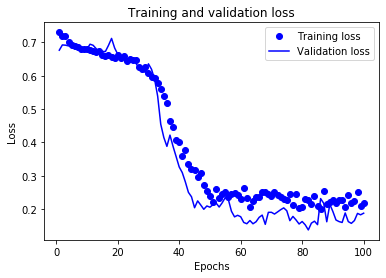

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

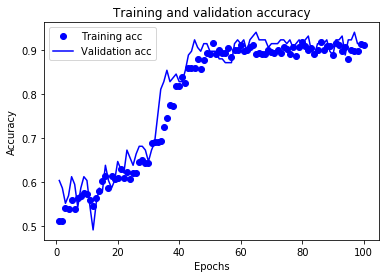

In [10]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Vanilla Knowledge Distillation

In [11]:
train_soft = teacher.predict(x=[train_X_data],
                           batch_size=batch_size,
                           verbose=True)
val_soft = teacher.predict(x=[val_X_data],
                         batch_size=batch_size,
                         verbose=True)
test_soft = teacher.predict(x=[test_X_data],
                          batch_size=batch_size,
                          verbose=True)
print(train_soft.shape)
print(val_soft.shape)
print(test_soft.shape)

773/773 [==============================] - 0s 128us/step
(1043, 2)
(116, 2)
(773, 2)


In [12]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

student_path = './models/checkpoints/{}-student.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=student_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

student, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=1.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = student.fit(x=[train_X_data, train_soft],
                    y=[train_Y_data],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_1/Softmax:0", shape=(?, 200), dtype=float32)
Train on 1043 samples, validate on 116 samples
Epoch 1/100
1043/1043 [==============================] - 1s 1ms/step - loss: 1.4740 - acc: 0.5072 - val_loss: 1.7268 - val_acc: 0.4569
Epoch 2/100
1043/1043 [==============================] - 0s 361us/step - loss: 1.5151 - acc: 0.4928 - val_loss: 1.4256 - val_acc: 0.4828
Epoch 3/100
1043/1043 [==============================] - 0s 366us/step - loss: 1.4116 - acc: 0.5187 - val_loss: 1.4024 - val_acc: 0.4914
Epoch 4/100
1043/1043 [==============================] - 0s 367us/step - loss: 1.4082 - acc: 0.4995 - val_loss: 1.3951 - val_acc: 0.5517
Epoch 5/100
1043/1043 [==============================] - 0s 365us/step - loss: 1.3838 - acc: 0.5331 - val_loss: 1.3911 - val_acc: 0.5517
Epoch 6/100
1043/1043 [==============================] - 0s 366us/step - loss: 1.3886 - acc: 0.5455 - val_loss: 1.3833 - val_acc: 0.5086
Epoch 7/100
1043/1043 [==============================] - 0s 363u

1043/1043 [==============================] - 0s 367us/step - loss: 0.5607 - acc: 0.9099 - val_loss: 0.4313 - val_acc: 0.9310
Epoch 60/100
1043/1043 [==============================] - 0s 364us/step - loss: 0.5670 - acc: 0.8917 - val_loss: 0.4841 - val_acc: 0.9052
Epoch 61/100
1043/1043 [==============================] - 0s 365us/step - loss: 0.5491 - acc: 0.9051 - val_loss: 0.4978 - val_acc: 0.8879
Epoch 62/100
1043/1043 [==============================] - 0s 367us/step - loss: 0.5924 - acc: 0.8917 - val_loss: 0.5034 - val_acc: 0.8966
Epoch 63/100
1043/1043 [==============================] - 0s 366us/step - loss: 0.5846 - acc: 0.8945 - val_loss: 0.4901 - val_acc: 0.9052
Epoch 64/100
1043/1043 [==============================] - 0s 365us/step - loss: 0.5830 - acc: 0.8936 - val_loss: 0.4837 - val_acc: 0.9052
Epoch 65/100
1043/1043 [==============================] - 0s 367us/step - loss: 0.5859 - acc: 0.8926 - val_loss: 0.4883 - val_acc: 0.8879
Epoch 66/100
1043/1043 [=======================

In [13]:
student.load_weights(student_path)
student_score = student.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of vanilla student: {}".format(student_score[1]))

Test Accuracy of vanilla student: 0.9146183608882948


## Contrastive Distillation for Text Classification

### Augmenting training data with single word perturbation

In [14]:
embeddings_index = load_word2vec()

In [15]:
idx2word = {}
for word, idx in tokenizer.word_index.items():
    idx2word[idx] = word

In [16]:
import random
from tqdm.notebook import tqdm

MAX_NB_TRIAL = 10
train_perturbed = []
for X in tqdm(train_X_data):
    ## 랜덤하게 단어 하나 선택해서
    nb_trial = 0
    while True:
        nb_trial += 1
        perturbed_pos = random.choice(range(np.nonzero(X)[0][0], len(X)))
        if X[perturbed_pos] != 0:
            target_word = idx2word[X[perturbed_pos]]
            if target_word in embeddings_index:
                break
        if nb_trial >= MAX_NB_TRIAL:
            print(X)
            break
    
    if nb_trial >= MAX_NB_TRIAL:
        train_perturbed.append(X)
        continue
    
    ## 데이터셋에서 등장했던 단어 중 비슷한 단어로 바꿔치기
    perturbed_X = np.copy(X)
    for similar_word, _ in embeddings_index.similar_by_word(target_word):
        if similar_word not in tokenizer.word_index:
            continue
        perturbed_X[perturbed_pos] = tokenizer.word_index[similar_word]
        break
    train_perturbed.append(perturbed_X)

[ 706 3485  415 2772    4  434  507 4161  260 3395    4  469  507 4161
  713 3395    4  469  354 1520  285 2217    4  907  712  513  639  321
    4  458  556 2773  212 2352    4  544 5291 1470  478 1937    4  877
  488  763   19  569  313    2  478 1628    2 2267  269    1  862  378
  313   19  862  378  269   19 2130 2969  545 2630    4  476  901 1604
 1924 2630    4  476 1201 3191  568 1937    4 7720    4  800  488  763
 2267  321    4  458 1201 3191  443 2217    4 7721    4  863  901 1604
 1792 4618    4  415  488  763  569  321    4  458  556 2773 1669 2630
    4  476  757 4619  362 2352    4  544  901 1604 1618 2352    4  544
  556 2773  362 2630    4  476  757 4619  610 2352    4  544 2130 2969
  362 2772    4  434  490  413  151   19  924 2774 3745 6187 1112  488
  763 2267 2970    8  909    4  503  591    6 1583 1015  504  653    8
  503    4  397  490    6 2345 1111  568  289    8  907    4  863  372
    6 2971 3486  568  298    8  909    4  503  309  398    6  251   20
   64 

In [17]:
# train_perturb_soft = teacher.predict(x=[train_perturbed, train_soft],
train_perturb_soft = teacher.predict(x=[train_perturbed],
                                     batch_size=batch_size,
                                     verbose=True)

train_X_contrastive = np.concatenate([train_X_data, train_perturbed])
train_soft_contrastive = np.concatenate([train_soft, train_perturb_soft])

print(train_X_contrastive.shape)
print(train_soft_contrastive.shape)

1043/1043 [==============================] - 0s 149us/step
(2086, 200)
(2086, 2)


In [18]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
                  # loss_weights=[0.0],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

contrastive_path = './models/checkpoints/{}-contrastive.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=contrastive_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

contrastive, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=1.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = contrastive.fit(x=[train_X_contrastive, train_soft_contrastive],
                    y=[np.concatenate([train_Y_data, train_Y_data])],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_2/Softmax:0", shape=(?, 200), dtype=float32)
Train on 2086 samples, validate on 116 samples
Epoch 1/100
2086/2086 [==============================] - 1s 709us/step - loss: 1.4842 - acc: 0.5086 - val_loss: 1.3857 - val_acc: 0.5431
Epoch 2/100
2086/2086 [==============================] - 1s 344us/step - loss: 1.4074 - acc: 0.5153 - val_loss: 1.3489 - val_acc: 0.6207
Epoch 3/100
2086/2086 [==============================] - 1s 344us/step - loss: 1.3780 - acc: 0.5479 - val_loss: 1.3655 - val_acc: 0.5690
Epoch 4/100
2086/2086 [==============================] - 1s 346us/step - loss: 1.3546 - acc: 0.5604 - val_loss: 1.3492 - val_acc: 0.5603
Epoch 5/100
2086/2086 [==============================] - 1s 344us/step - loss: 1.3306 - acc: 0.5983 - val_loss: 1.3062 - val_acc: 0.6638
Epoch 6/100
2086/2086 [==============================] - 1s 342us/step - loss: 1.3077 - acc: 0.6218 - val_loss: 1.2149 - val_acc: 0.7241
Epoch 7/100
2086/2086 [==============================] - 1s 34

2086/2086 [==============================] - 1s 347us/step - loss: 0.4778 - acc: 0.9214 - val_loss: 0.4192 - val_acc: 0.9224
Epoch 60/100
2086/2086 [==============================] - 1s 348us/step - loss: 0.4768 - acc: 0.9267 - val_loss: 0.4314 - val_acc: 0.9224
Epoch 61/100
2086/2086 [==============================] - 1s 349us/step - loss: 0.4848 - acc: 0.9281 - val_loss: 0.4515 - val_acc: 0.9052
Epoch 62/100
2086/2086 [==============================] - 1s 349us/step - loss: 0.4690 - acc: 0.9252 - val_loss: 0.4666 - val_acc: 0.8966
Epoch 63/100
2086/2086 [==============================] - 1s 348us/step - loss: 0.4711 - acc: 0.9338 - val_loss: 0.4531 - val_acc: 0.9138
Epoch 64/100
2086/2086 [==============================] - 1s 348us/step - loss: 0.4737 - acc: 0.9262 - val_loss: 0.4497 - val_acc: 0.9052
Epoch 65/100
2086/2086 [==============================] - 1s 348us/step - loss: 0.4717 - acc: 0.9286 - val_loss: 0.4504 - val_acc: 0.9052
Epoch 66/100
2086/2086 [=======================

In [19]:
contrastive.load_weights(contrastive_path)
contrastive_score = contrastive.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of contrastive student: {}".format(contrastive_score[1]))

Test Accuracy of contrastive student: 0.923674006742771


In [23]:
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Layer
from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Multiply
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1].value, self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation


def SeqAtt(embedding_matrix,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           mu_distillation=1.0,
           optimizer = keras.optimizers.Adam(lr=0.001)):
    
    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sequence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sequence = embedding_layer(sequence_input)
    embedded_sequence = Dropout(dense_dropout)(embedded_sequence)
    contextualized_sequence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sequence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sequence)
    print(word_attention)
    # Tensor("attention_layer_2/Softmax:0", shape=(?, 180), dtype=float32)
        
    sequence_representation = WeightedSum(word_attention, contextualized_sequence)
        
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(sequence_representation)

    ############### attention supervision processing ###############
    soft_label = Input(shape=(nb_classes, ), dtype='float32')  # should it be logit?
    
    ############### build attention extractor ###############
    model = Model(inputs=[sequence_input, soft_label],
                  outputs=[pred_sentiment])
    
    attention_extractor = Model(inputs=[sequence_input],
                                     outputs=[word_attention])
    sequence_encoder = Model(inputs=[sequence_input],
                             outputs=[contextualized_sequence])
    classifier_module = fc_layers
    
    model.add_loss(mu_distillation * K.mean(K.mean(K.binary_crossentropy(soft_label, pred_sentiment))))
    
    model.compile(loss=['categorical_crossentropy'],
                  # loss_weights=[0.0],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sequence_encoder, classifier_module

augmented_path = './models/checkpoints/{}-augmented.h5'.format(dataset_name)
checkpointer = ModelCheckpoint(filepath=augmented_path,
                               monitor='val_acc',
                               verbose=False,
                               save_best_only=True,
                               mode='max')

augmented, attention_extractor, sequence_encoder, classifier_module = SeqAtt(embedding_matrix=embedding_matrix,
                                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                                    nb_classes=nb_classes,
                                                    embedding_dim=args['embedding_dim'],
                                                    attention_dim=args['attention_dim'],
                                                    rnn_dim=args['rnn_dim'],
                                                    include_dense_batch_normalization=args['include_dense_batch_normalization'],
                                                    include_dense_dropout=args['include_dense_dropout'],
                                                    nb_dense=args['nb_dense'],
                                                    dense_dim=args['dense_dim'],
                                                    dense_dropout=args['dense_dropout'],
                                                    mu_distillation=0.0,
                                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = augmented.fit(x=[train_X_contrastive, train_soft_contrastive],
                    y=[np.concatenate([train_Y_data, train_Y_data])],
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=True,
                    validation_data=([val_X_data, val_soft], val_Y_data),
                    callbacks=[checkpointer])

Tensor("attention_layer_4/Softmax:0", shape=(?, 200), dtype=float32)
Train on 2086 samples, validate on 116 samples
Epoch 1/100
2086/2086 [==============================] - 2s 789us/step - loss: 0.7672 - acc: 0.5173 - val_loss: 0.7014 - val_acc: 0.5000
Epoch 2/100
2086/2086 [==============================] - 1s 351us/step - loss: 0.7143 - acc: 0.4904 - val_loss: 0.6926 - val_acc: 0.5345
Epoch 3/100
2086/2086 [==============================] - 1s 352us/step - loss: 0.6954 - acc: 0.5307 - val_loss: 0.6894 - val_acc: 0.5517
Epoch 4/100
2086/2086 [==============================] - 1s 349us/step - loss: 0.7045 - acc: 0.5278 - val_loss: 0.6879 - val_acc: 0.5431
Epoch 5/100
2086/2086 [==============================] - 1s 351us/step - loss: 0.6869 - acc: 0.5470 - val_loss: 0.6824 - val_acc: 0.5345
Epoch 6/100
2086/2086 [==============================] - 1s 350us/step - loss: 0.6830 - acc: 0.5518 - val_loss: 0.6916 - val_acc: 0.5086
Epoch 7/100
2086/2086 [==============================] - 1s 35

2086/2086 [==============================] - 1s 351us/step - loss: 0.1756 - acc: 0.9319 - val_loss: 0.1938 - val_acc: 0.9138
Epoch 60/100
2086/2086 [==============================] - 1s 353us/step - loss: 0.1648 - acc: 0.9358 - val_loss: 0.2288 - val_acc: 0.8966
Epoch 61/100
2086/2086 [==============================] - 1s 350us/step - loss: 0.1696 - acc: 0.9300 - val_loss: 0.2499 - val_acc: 0.8793
Epoch 62/100
2086/2086 [==============================] - 1s 352us/step - loss: 0.1658 - acc: 0.9291 - val_loss: 0.2643 - val_acc: 0.9052
Epoch 63/100
2086/2086 [==============================] - 1s 352us/step - loss: 0.1489 - acc: 0.9415 - val_loss: 0.2953 - val_acc: 0.8793
Epoch 64/100
2086/2086 [==============================] - 1s 353us/step - loss: 0.1548 - acc: 0.9367 - val_loss: 0.2983 - val_acc: 0.8793
Epoch 65/100
2086/2086 [==============================] - 1s 350us/step - loss: 0.1476 - acc: 0.9396 - val_loss: 0.3041 - val_acc: 0.8793
Epoch 66/100
2086/2086 [=======================

In [24]:
augmented.load_weights(augmented_path)
augmented_score = augmented.evaluate([test_X_data, test_soft], test_Y_data, verbose=0, batch_size=batch_size)
print("Test Accuracy of augmented dataset: {}".format(augmented_score[1]))

Test Accuracy of augmented dataset: 0.9042690837367848


### Training with knowledge distillation

## Saving attentions

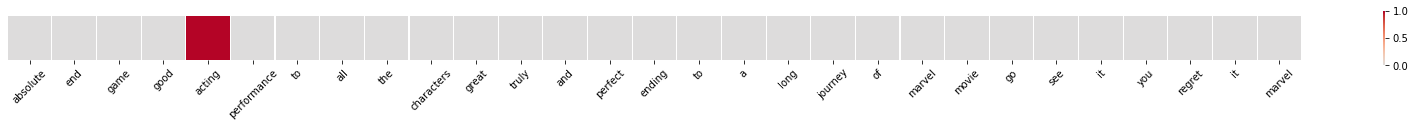

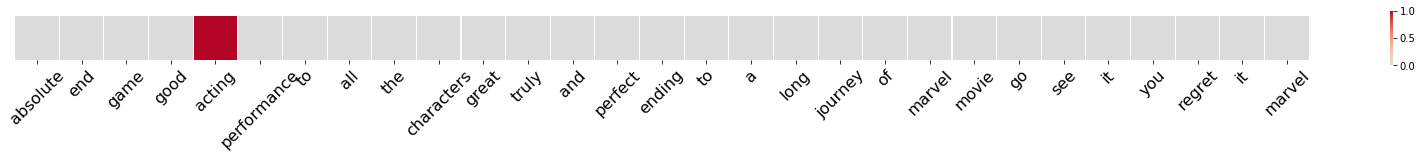

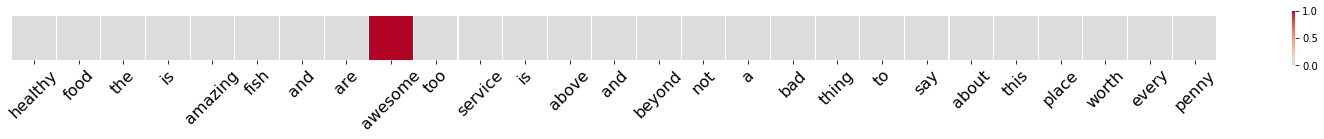

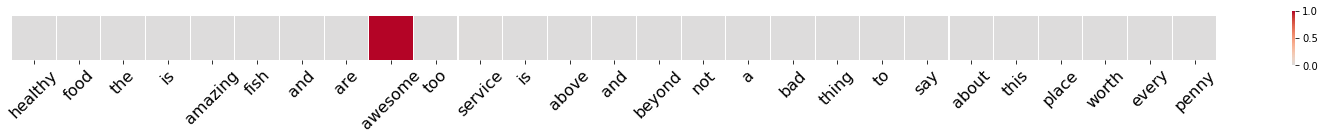

In [22]:
import matplotlib.pyplot as plt
import seaborn as sn

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def hierarchical_attention_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        
def sequential_attention_analysis(review):        
    tokenized_sentence = doc2sequential(review)
    
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentence]))[0]
    
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if tokenized_sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in tokenized_sentence[word_idx:]]
            pred_att = pred_attention[-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('xtick', labelsize=16)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
    plt.xticks(rotation=45)
    plt.show()
    
def sequential_normatt_analysis(review):        
    tokenized_sentence = doc2sequential(review)
    
    pred_representations = sequence_encoder.predict(np.asarray([tokenized_sentence]))[0]
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentence]))[0]
    weighted_representations = pred_representations * np.expand_dims(pred_attention, axis=-1)
    normatt = np.linalg.norm(weighted_representations, axis=-1)
    
    # print(pred_attention)
    
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if tokenized_sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in tokenized_sentence[word_idx:]]
            pred_att = normatt[-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

    fig, ax = plt.subplots(figsize=(len(words), 1))
    plt.rc('xtick', labelsize=16)
    midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
    heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmax=1.0)
    plt.xticks(rotation=45)
    plt.show()
        
# hierarchical_attention_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")
# sequential_attention_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")

target_review = "Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic and perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"
sequential_attention_analysis(target_review)
sequential_normatt_analysis(target_review)

# target_review = "Marvel 's The Avengers is quite possibly the greatest superhero movie in history. The combination of heroes mixes itself together into a concoction of personalities and superpowers which guarantees to impress."
target_review = "Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!"
sequential_attention_analysis(target_review)
sequential_normatt_analysis(target_review)